In [ ]:
import librosa
import numpy as np
import os
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import soundfile as sf
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Preparation

In [5]:
# Load audio file
audio_path = "our_dataset.mp3"  # Replace with your file
clean_audio, sr = librosa.load(audio_path, sr=None)

# Add noise
def add_noise(audio, noise_level=0.02):
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

noisy_audio = add_noise(clean_audio)

# Save noisy and clean chunks
chunk_size = sr  # 1-second chunks
# print(chunk_size)
chunks_clean = [clean_audio[i:i+chunk_size] for i in range(0, len(clean_audio), chunk_size)]
chunks_noisy = [noisy_audio[i:i+chunk_size] for i in range(0, len(noisy_audio), chunk_size)]

def chunks_to_tensor(chunks):
    return torch.tensor([librosa.util.fix_length(chunk, size=chunk_size) for chunk in chunks])

X = chunks_to_tensor(chunks_noisy)
Y = chunks_to_tensor(chunks_clean)

class AudioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = AudioDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [6]:
clean_audio.min()

np.float32(-0.9332344)

In [7]:
clean_audio.max()

np.float32(0.9784326)

In [8]:
noisy_audio = add_noise(clean_audio)

noisy_audio_path = "noisy_dataset.wav"
sf.write(noisy_audio_path, noisy_audio, sr)
print(f"Noisy audio saved to {noisy_audio_path}")

Noisy audio saved to noisy_dataset.wav


## Model Architecture

In [9]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
        )
 
    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  
 
    def forward(self, x):
        features = self.conv_block(x)
        pooled = self.pool(features)
        return features, pooled

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(out_channels + skip_channels, out_channels)
 
    def forward(self, x, skip_features):
        x = self.upconv(x)
        x = torch.cat([x, skip_features], dim=1)  
        x = self.conv_block(x)
        return x

class UNetAudio(nn.Module):
    def __init__(self, input_channels=1, num_classes=1):
        super(UNetAudio, self).__init__()
        
        self.encoder1 = EncoderBlock(input_channels, 16)
        self.encoder2 = EncoderBlock(16, 32)
        self.encoder3 = EncoderBlock(32, 64)
        self.encoder4 = EncoderBlock(64, 128)
        
        self.bottleneck = ConvBlock(128, 256)
        
        self.decoder1 = DecoderBlock(256, 128, 128)
        self.decoder2 = DecoderBlock(128, 64, 64)
        self.decoder3 = DecoderBlock(64, 32, 32)
        self.decoder4 = DecoderBlock(32, 16, 16)
        
        self.final_conv = nn.Conv1d(16, num_classes, kernel_size=1) 

    def forward(self, x):
        # Encoer
        s1, p1 = self.encoder1(x)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)
        # print(f"the s4 in the encoder part {s4.size()} ,and the p4 in the encoder part {p4.size()}")
        
        # Bottleneck
        b = self.bottleneck(p4)
        # print(b.size())
        
        # Decoder with skip connections
        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)
        # print(d4.size())
        
        # Final output
        outputs = self.final_conv(d4)
        return outputs


model = UNetAudio(input_channels=1, num_classes=1) 


In [ ]:
import torch
from tqdm import tqdm  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

loss_fn = torch.nn.MSELoss()

class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, save_path="best_model.h5"):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_model(self, model):
        torch.save(model.state_dict(), self.save_path)
        print(f"Model saved to {self.save_path}")

def train_model(model, train_loader, val_loader, epochs=15, patience=5):
    early_stopping = EarlyStopping(patience=patience, save_path="best_model.h5")
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        model.train()
        train_loss = 0
        train_progress = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)
        for noisy, clean in train_progress:
            noisy, clean = noisy.unsqueeze(1).float().to(device), clean.unsqueeze(1).float().to(device)
            optimizer.zero_grad()
            output = model(noisy)
            loss = loss_fn(output, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_progress.set_postfix({"Batch Loss": loss.item()})

        model.eval()
        val_loss = 0
        val_progress = tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", leave=False)
        with torch.no_grad():
            for noisy, clean in val_progress:
                noisy, clean = noisy.unsqueeze(1).float().to(device), clean.unsqueeze(1).float().to(device)
                output = model(noisy)
                loss = loss_fn(output, clean)
                val_loss += loss.item()
                val_progress.set_postfix({"Batch Loss": loss.item()})

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    print("Loading best model...")
    model.load_state_dict(torch.load(early_stopping.save_path))
    print("Model loaded!")

train_model(model, train_loader, val_loader, epochs=40, patience=9)


In [ ]:
import soundfile as sf
import numpy as np
import torch
import librosa
import os

def load_model(model_class, weight_path, device):

    model = model_class().to(device) 
    model.load_state_dict(torch.load(weight_path)) 
    model.eval() 
    print(f"Model loaded from '{weight_path}'")
    return model

def save_model_output_as_audio(model, dataset, output_path, device, duration_minutes=6, sample_rate=48000):

    model.eval()
    
    duration_samples = duration_minutes * 60 * sample_rate
    
    predicted_audio = []
    
    with torch.no_grad():
        for noisy, clean in dataset:
            noisy = noisy.unsqueeze(0).unsqueeze(0).float().to(device)  
            
            output = model(noisy)
            
            output_audio = output.squeeze(0).squeeze(0).cpu().numpy() 
            
            predicted_audio.append(output_audio)
    
    predicted_audio = np.concatenate(predicted_audio, axis=0)
    
    predicted_audio = predicted_audio[:duration_samples]
    
    sf.write(output_path, predicted_audio, sample_rate)
    print(f"Predicted audio saved as '{output_path}'")


model_path = "best_model.h5"  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(UNetAudio, model_path, device)

output_path = "predicted_output_1.wav"
save_model_output_as_audio(model, dataset = dataset, output_path = output_path, device = device)


C:\Users\hadi.khadim\AppData\Local\Temp\ipykernel_19900\2751994331.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))  # Loa

Model loaded from 'best_model.h5'
Predicted audio saved as 'predicted_output_1.wav'


## postprocess

In [ ]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf

audio_path = "predicted_output_1.wav"  
audio, sr = librosa.load(audio_path, sr=None)

def dynamic_range_compression(audio, threshold=0.05, ratio=4):
    compressed_audio = []
    for sample in audio:
        if abs(sample) > threshold:
            compressed_audio.append(np.sign(sample) * (threshold + (abs(sample) - threshold) / ratio))
        else:
            compressed_audio.append(sample)
    return np.array(compressed_audio)

compressed_audio = dynamic_range_compression(audio)

def equalize(audio, sr):
    low_cutoff = 300.0
    high_cutoff = 2000.0
    fft = np.fft.rfft(audio)
    freqs = np.fft.rfftfreq(len(audio), 1/sr)
    fft[(freqs < low_cutoff) | (freqs > high_cutoff)] = 0
    return np.fft.irfft(fft)

equalized_audio = equalize(compressed_audio, sr)

def normalize(audio, target_dB=-20.0):
    rms = np.sqrt(np.mean(audio**2))
    scalar = 10**(target_dB / 20) / rms
    return audio * scalar

normalized_audio = normalize(equalized_audio)

enhanced_audio_path = "enhanced_predicted_output_1.wav"
sf.write(enhanced_audio_path, normalized_audio, sr)
print(f"Enhanced audio saved to {enhanced_audio_path}")


Enhanced audio saved to enhanced_predicted_output_1.wav


In [ ]:
import librosa
import noisereduce as nr
import soundfile as sf
import numpy as np

audio, sr = librosa.load("predicted_output_1.wav", sr=None)

noise_sample = audio[:10000]
audio_denoised = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_sample, prop_decrease=0.8)

compressed_audio = librosa.effects.percussive(audio_denoised)

harmonic, _ = librosa.effects.hpss(compressed_audio)  

audio_normalized = librosa.util.normalize(harmonic)

sf.write("processed_output_b.wav", audio_normalized, sr)


c:\Users\hadi.khadim\Documents\CureMD_Job\sp-10\GenAI\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Testing and Evaluation

## Visualization

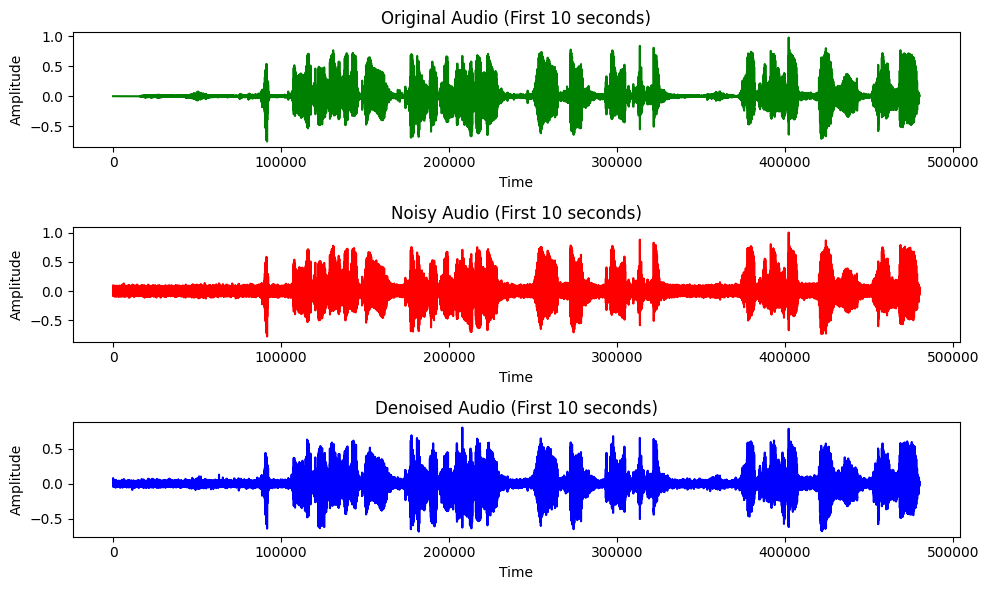

In [ ]:
import soundfile as sf

test_duration = 360  
chunk_size = 48000 
total_chunks = test_duration  

denoised_audio = []

for i in range(total_chunks):
    test_chunk = noisy_audio[i*chunk_size:(i+1)*chunk_size].astype(np.float32)  
    test_chunk_tensor = torch.tensor(test_chunk).unsqueeze(0).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        denoised_chunk = model(test_chunk_tensor).squeeze().cpu().numpy()

    denoised_audio.append(denoised_chunk)

denoised_audio_combined = np.concatenate(denoised_audio, axis=0)

sf.write("predicted_output_1.wav", denoised_audio_combined, samplerate=22050)

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.title("Original Audio (First 10 seconds)")
plt.plot(clean_audio[:10*chunk_size], color="green")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.title("Noisy Audio (First 10 seconds)")
plt.plot(noisy_audio[:10*chunk_size], color="red")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.title("Denoised Audio (First 10 seconds)")
plt.plot(denoised_audio_combined[:10*chunk_size], color="blue")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

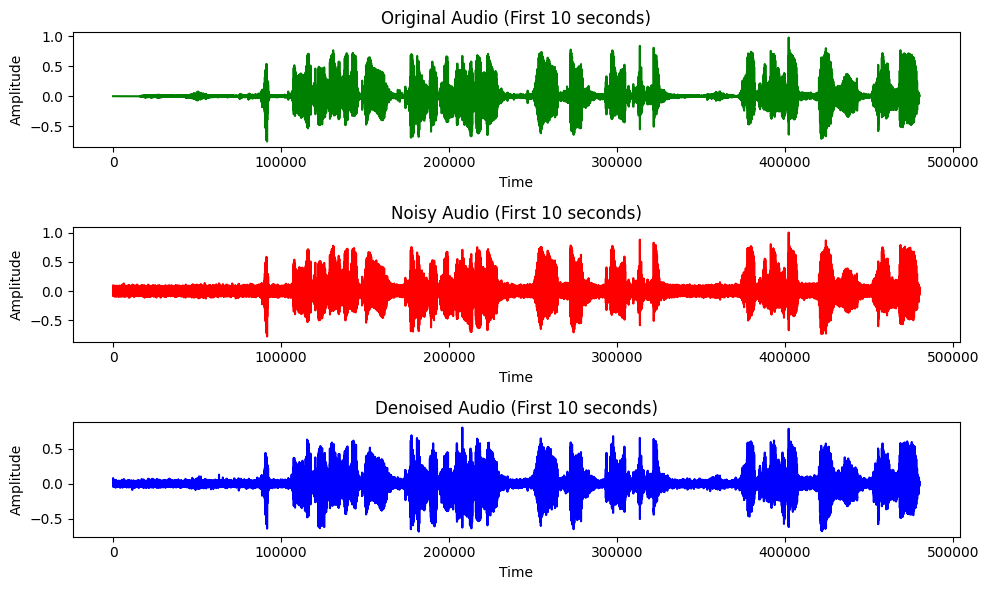

In [ ]:
import soundfile as sf

train_duration = 360  
chunk_size = 48000  
total_chunks = train_duration  

denoised_audio = []

for i in range(total_chunks):
    train_chunk = noisy_audio[i*chunk_size:(i+1)*chunk_size].astype(np.float32)  
    train_chunk_tensor = torch.tensor(train_chunk).unsqueeze(0).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        denoised_chunk = model(train_chunk_tensor).squeeze().cpu().numpy()

    denoised_audio.append(denoised_chunk)

denoised_audio_combined = np.concatenate(denoised_audio, axis=0)

sf.write("predicted_output_1.wav", denoised_audio_combined, samplerate=22050)

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.title("Original Audio (First 10 seconds)")
plt.plot(clean_audio[:10*chunk_size], color="green")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.title("Noisy Audio (First 10 seconds)")
plt.plot(noisy_audio[:10*chunk_size], color="red")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.title("Denoised Audio (First 10 seconds)")
plt.plot(denoised_audio_combined[:10*chunk_size], color="blue")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()